#### Импорт библиотек

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation, Embedding

from tensorflow.keras.optimizers import Adam, RMSprop
from keras.layers import Input, Reshape, Dropout
from keras import Model

from keras.layers import RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.model_selection import GridSearchCV
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
import math
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler

### Загрузка данных

In [2]:
df = pd.read_csv('datasets/1018566_19.csv')

In [3]:
y = df['t_trp']

In [153]:
# df_1 = df.groupby('time')['t_trp'].mean()

In [5]:
# y = df_1.values
# y.shape

### Стандартизация

In [9]:
y = y.values.reshape(-1, 1)

In [11]:
sc = StandardScaler()
y_sc = sc.fit_transform(y)

In [12]:
y_sc = np.reshape(y_sc, (y_sc.shape[0]))

### Создадим X

In [13]:
def create_x(arr, n_features=3):
    x, y = [], []
    for i in range(len(arr)-n_features-1):
        a = arr[i:(i+n_features)]
        x.append(a)
        y.append(arr[i + n_features])
    return np.array(x), np.array(y)

In [14]:
n_features=200
X, y = create_x(y, n_features)

### Разбиваем на train, test

In [15]:
num = int(len(y)*0.8)

In [16]:
x_train, y_train = X[:num], y[:num]
x_test, y_test = X[num:], y[num:]

### Переводим в Тензор

In [17]:
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

In [18]:
print(x_train.shape)
print(x_test.shape)

(66691, 1, 200)
(16673, 1, 200)


### Создадим модель LSTM

In [19]:
num_cells=50
dropout_rate=0.1
lr=0.01
n_features = 12
timesteps = x_train.shape[1]

In [20]:
def init_model(num_cells, dropout_rate, lr, n_features, timesteps):
    model = Sequential()
    model.add(LSTM(
             units=num_cells,
             return_sequences=True,
             input_shape=(timesteps, n_features)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(
              units=num_cells,
              return_sequences=False))
    model.add(Dropout(lr))
    model.add(Dense(units=1, activation='relu'))
    model.add(Activation("relu"))
    optimiser = Adam(learning_rate=lr)
    model.compile(loss="mse", optimizer=optimiser, metrics=['mse'])
    return model

In [21]:
def fit_model(model, x, y, batch_size=200):
    hist = model.fit(x, y, epochs=40, batch_size=batch_size, validation_split=0.2, verbose=0,
              callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])
    return hist

In [22]:
def plt_mse(hist):
    %matplotlib inline
    plt.figure()
    plt.plot(hist.history['mse'])
    plt.plot(hist.history['val_mse'])
    plt.title('MSE')
    plt.ylabel('Mean Squared Error')
    plt.xlabel('# Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('Epoch.png', dpi=1200) 
    plt.show()

In [23]:
def get_rmse_score(pred, y):
    return math.sqrt(mean_squared_error(y, pred))

### Обучим модель

In [24]:
num_cells = 32
dropout_rate = 0.1
lr= 0.01

In [28]:
n_features = 200
timesteps = x_train.shape[1]

In [29]:
model = Sequential()
model.add(LSTM(
         units=64,
         return_sequences=True,
         input_shape=(timesteps, n_features)))
model.add(Dropout(0.1))
model.add(LSTM(
          units=32,
          return_sequences=False))
model.add(Dropout(0.01))
model.add(Dense(units=1, activation='relu'))
model.add(Activation("relu"))
optimiser = Adam(learning_rate=0.01)
model.compile(loss="mse", optimizer=optimiser, metrics=['mse'])

In [30]:
hist = model.fit(x_train, y_train, epochs=40, batch_size=200, validation_split=0.2, verbose=2,
              callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])

Epoch 1/40
267/267 - 6s - loss: 0.1353 - mse: 0.1353 - val_loss: 0.0833 - val_mse: 0.0833 - 6s/epoch - 23ms/step
Epoch 2/40
267/267 - 2s - loss: 0.0753 - mse: 0.0753 - val_loss: 0.0604 - val_mse: 0.0604 - 2s/epoch - 6ms/step
Epoch 3/40
267/267 - 2s - loss: 0.0633 - mse: 0.0633 - val_loss: 0.0677 - val_mse: 0.0677 - 2s/epoch - 6ms/step
Epoch 4/40
267/267 - 2s - loss: 0.0576 - mse: 0.0576 - val_loss: 0.0473 - val_mse: 0.0473 - 2s/epoch - 7ms/step
Epoch 5/40
267/267 - 2s - loss: 0.0538 - mse: 0.0538 - val_loss: 0.0593 - val_mse: 0.0593 - 2s/epoch - 6ms/step
Epoch 6/40
267/267 - 2s - loss: 0.0528 - mse: 0.0528 - val_loss: 0.0594 - val_mse: 0.0594 - 2s/epoch - 6ms/step
Epoch 7/40
267/267 - 2s - loss: 0.0510 - mse: 0.0510 - val_loss: 0.0641 - val_mse: 0.0641 - 2s/epoch - 6ms/step
Epoch 8/40
267/267 - 2s - loss: 0.0513 - mse: 0.0513 - val_loss: 0.0613 - val_mse: 0.0613 - 2s/epoch - 6ms/step
Epoch 9/40
267/267 - 2s - loss: 0.0489 - mse: 0.0489 - val_loss: 0.0816 - val_mse: 0.0816 - 2s/epoch - 

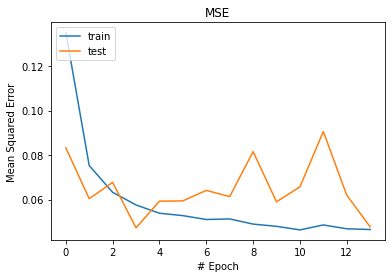

In [31]:
plt.figure()
plt.plot(hist.history['mse'])
plt.plot(hist.history['val_mse'])
plt.title('MSE')
plt.ylabel('Mean Squared Error')
plt.xlabel('# Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Epoch.png', dpi=1200) 
plt.show()

In [32]:
pred = model.predict(x_test)
get_rmse_score(pred, y_test)

0.24455415156447594

### Предсказание

In [33]:
trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)

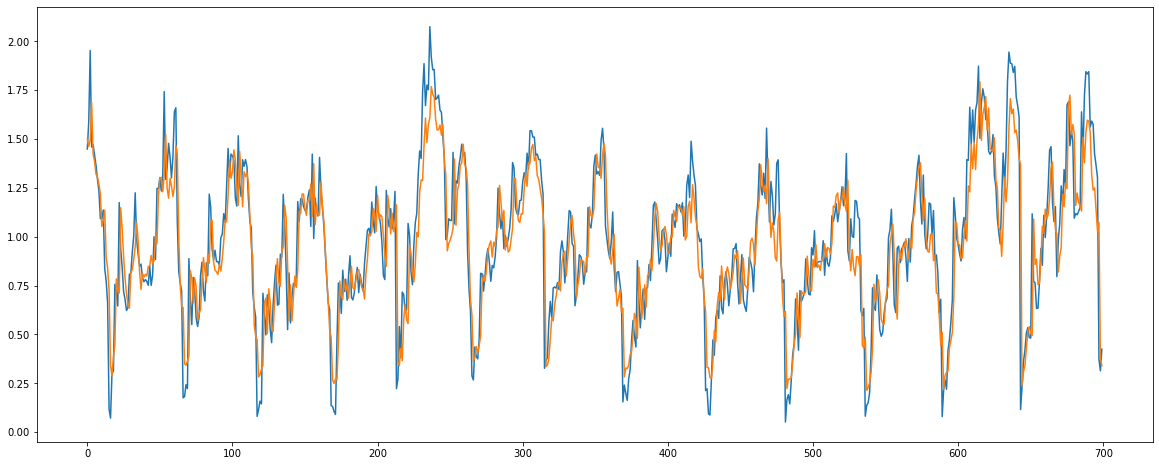

In [34]:
plt.figure(figsize=(20,8))
plt.plot(y_test[-700:])
plt.plot(testPredict[-700:])

### Предскажем значения на месяц вперед

У нас есть 30 дней с 24 часами, получается 720 промежутков

In [35]:
def update_x(x, pred):
    
    # удаляем первое значение, в окнец добавляем новое предсказанное
    x_without_first = np.delete(x, 0)
    x_with_pred = np.append(x_without_first, pred)

    x = np.reshape(x_with_pred, (1, 1, x_with_pred.shape[0]))
    return x

In [36]:
def predict(model, num, x):
    x_one = np.reshape(x, (1, x.shape[0], x.shape[1]))
    predict_arr = []
    
    for i in range(num):
        
        pred = model.predict(x_one)
        predict_arr.append(float(pred))
        x_one = update_x(x_one, pred)
        
    return predict_arr

In [37]:
pred = predict(model, 700, x_test[-1])

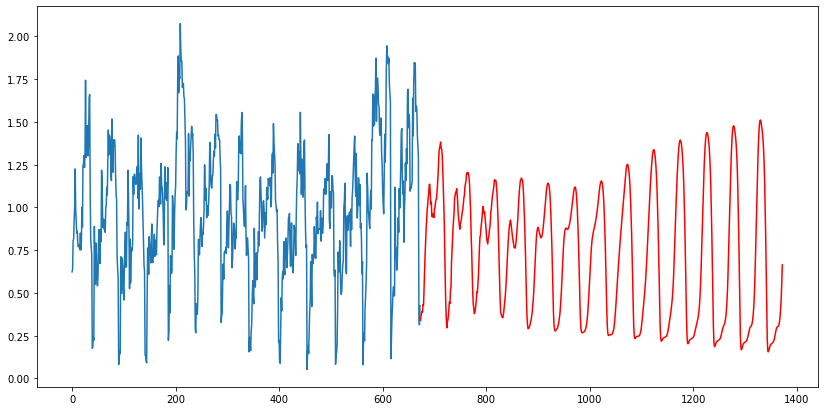

In [41]:
plt.figure(figsize=(14, 7))
plt.plot(y_test[16000:])
plt.plot([None for i in range(673)]+pred, color='r')